# <center>Dynamique des épidémies


On commence par importer les bibliothèques nécessaires à l'éxécution du programme

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import imageio

On initialise ensuite les paramètres de l'expérience.
Pour commencer, on défini les couleurs dans lesquelles nos matrices d'états et de comportements seront affichées ainsi que leur taille.

In [14]:
couleurs_etat=['green','blue','red'] #Couleurs disponibles à la modélisation des états 
couleurs_comportement=['green','green','orange','orange','yellow','red']#Couleurs disponibles à la modélisation des comportements
NB_LIGNES=100 #Nombre de lignes du tableau
NB_COLONNES=100 #Nombre de colonnes du tableau

Différentes probabilités nous seront nécessaires pour initialiser les cases de certaines de nos matrices.

In [3]:
PROB_INFECTE = 0.1 #Probabilité d'être infecté au premier tour
PROB_REMISSION = 0.05 #Probabilité d'être en rémission au premier tour
PROB_COMPORTEMENT_2 = 0.1 #Probabilité d'avoir le comportement 2
PROB_COMPORTEMENT_4 = 0.05 #Probabilité d'avoir le comportement 4
PROB_COMPORTEMENT_5 = 0.05 #Probabilité d'avoir le comportement 5

On détermine les caractéristiques des clusters qu'on voudrait créer.

In [4]:
#Coordonnées du Cluster d'états
X_CLUSTER_ETAT = 0 
Y_CLUSTER_ETAT = 0
#Coordonnées du Cluster de comportement
X_CLUSTER_COMPORTEMENT = 0
Y_CLUSTER_COMPORTEMENT = 0
#Taille des clusters
TAILLE_CLUSTER_ETAT = 0
TAILLE_CLUSTER_COMPORTEMENT = 15
#Etat des clusters
ETAT_CLUSTER_ETAT = 0
ETAT_CLUSTER_COMPORTEMENT = 5

On liste ensuite les différents paramètres liés à l'évolution du plateau.

In [13]:
SEUIL_EPIDEMIQUE = 20
PROB_INFECTE_INCREMENTATION = [0.75,0.9,0.5,0.65,0.75,0.5] #Probabilité d'incrémenter son compteur pour passer d'infécté à personne en rémission selon le comportement
PROB_REMISSION_INCREMENTATION = [0.75,0.9,0.5,0.65,0.75,0.5] #Probabilité d'incrémenter son compteur pour passer de personne en rémission à personne saine selon le comportement
TAUX_INFECTION = [6,8,4,5,6,4] #Valeur minimum d'infection autour du sujet pour infecter celui-ci selon son comportement
TAUX_REINFECTION = [4,5,3,4,4,3] #Nombre d'infectés minimums necéssaires à la réinfection du sujet si celui-ci est en rémission selon son comportement
TEMPS_INFECTE = [3,2,5,4,3,5] #Nombre de tours nécessiares à une infecté pour passer en rémission selon son comportement
TEMPS_REMISSION = [3,2,5,4,3,5] #Nombre de tours nécessiares à une personne en rémission pour redevenir saine selon son comportement
TEMPS_IMMUNISE = 3 #Nombre de tours d'immunité à la fin d'une infection
NB_REINFECTION=2 #Nombre de réinfections possible avant l'immunité du sujet
NB_INFECTES_TOUR_SUIVANT=0 #Nombre d'infectés à un instant t+1

NB_TOURS = 1 #Nombre de tours de simulation

On commence tout d'abord par coder deux fonctions nous permettant d'obtenir différents nombres aléatoires selon une répartition non-équiprobable.

In [6]:
def rand_prob_infecte(prob1, prob2):
    #Définie un nombre aleatoire correspondant à un état
    """Prob doit être donnée en frequence"""
    res = random.random()
    if res>prob1+prob2:
        return 0
    if res>prob2:
        return 1
    return 2
        
####################################################################################################################

def rand_prob_comportement(prob1, prob2, prob3):
    #Définie un nombre aléatoire correspondant à un comportement
    res = random.random()
    if res>prob1+prob2+prob3:
        return 0
    if res>prob2+prob3:
        return 2
    if res>prob3:
        return 4
    return 5
####################################################################################################################

def incrementation_alea(prob):
    #Renvoie aléatoirement 0 ou 1 avec une probabilité prob 
    res = random.random()
    if res>prob:
        return 0
    return 1

Il convient ensuite d'initialiser le plateau de manière aléatoire puis d'utiliser une fonction permettant de créer des clusters.

In [7]:
def ini_plateau(ligne,colonne):
    #Initialise un plateau de jeu de la taille indiquée
    plateau = np.zeros([4,ligne,colonne]).astype(int)
    for l in range(ligne):
        for c in range(colonne):
            plateau[0][l][c]=rand_prob_infecte(PROB_REMISSION, PROB_INFECTE)
            plateau[3][l][c]=rand_prob_comportement(PROB_COMPORTEMENT_2,PROB_COMPORTEMENT_4,PROB_COMPORTEMENT_5)
    return plateau

####################################################################################################################

def cluster(plateau,x,y,cote,matrice,etat):
    #Créer un cluster carré selon des coordonnées de départ un côté et un état dans la matrice souhaitée
    ligne=plateau.shape[1]
    colonne=plateau.shape[2]
    for l in range(x+1,x+cote+1):
        for c in range(y+1,y+cote+1):
            plateau[matrice][(x+l-1)%ligne][(y+c-1)%colonne] = etat
    return plateau

Il est ensuite utile d'avoir des fonctions pour calculer le nombre d'infectés ainsi que leur pourcentage.

In [8]:
def nb_infectes(plateau):
    #Retourne le nombre d'individus infectés sur le plateau
    nb_inf = 0
    ligne=plateau.shape[1]
    colonne=plateau.shape[2]
    for l in range(ligne):
        for c in range(colonne):
            if plateau[0][l][c] == 2:
                nb_inf+=1
    return nb_inf

#####################################################################################################################

def pourcentage_infec(plateau):
    #Renvoie le pourcentage d'individus infectés sur le plateau
    ligne=plateau.shape[1]
    colonne=plateau.shape[2]
    return nb_infectes(plateau)/(ligne*colonne)*100

#####################################################################################################################

def nouv_cas_infec(plateau,nouv_plateau):
    #Retourne le nombre de nouvelles infections entre deux tours
    ligne=plateau.shape[1]
    colonne=plateau.shape[2]
    nouv_cas=0
    for l in range(ligne):
        for c in range(colonne):
            if plateau[0][l][c] != 2 and nouv_plateau[0][l][c] == 2:
                nouv_cas+=1
    return nouv_cas

Vient ensuite le moment de faire évoluer le plateau en extrayant les données sur les voisins dans une matrice externe.

In [9]:
def matrice_voisins(l,c,plateau,nouv_infectes):
    """Extrait la matrice 3x3 autour de la coordonée choisie, 
    puis applique à la cellule centrale les règles d'évolution,
    et retourne la liste contenant son état et son compteur après l'évolution"""
    
    #EXTRACTION
        #Création d'un plateau 3x3
    nbr_ligne=plateau.shape[1]
    nbr_colonne=plateau.shape[2]
    matrice=np.zeros([4,3,3], dtype=int)
        #Remplissage du nouveau plateau
    for x in range(3):
        for y in range(3):
            matrice[0][x][y] = plateau[0][(l+x-1)%nbr_ligne][(c+y-1)%nbr_colonne]
    #Prise en compte des changements de comportements dûs au dépassement du seuil épidémique  
    if nouv_infectes >= SEUIL_EPIDEMIQUE:
        if plateau[3][l][c] == 0 or plateau[3][l][c] == 2:
            matrice[3][1][1] = plateau[3][l][c]+1
        else:
            matrice[3][1][1] = plateau[3][l][c]
    else:
            matrice[3][1][1] = plateau[3][l][c]
    matrice[1][1][1] = plateau[1][l][c]
    matrice[2][1][1] = plateau[2][l][c]
    
    #ANALYSE DU TABLEAU
#On initialise la somme à l'opposé de la valeur de la cellule centrale
#pour que cette valeur s'annule lorsqu'on parcourt le tableau
    somme=-matrice[0][1][1]
    nb_infectes=0
    for x in range(3):
        for y in range(3):
            somme+=matrice[0][x][y]
            if matrice[0][x][y]==2:
                nb_infectes+=1
    
    #EVOLUTION
        #Personne saine
    if matrice[0][1][1]==0:
        if matrice[1][1][1]==0:
            if somme>=TAUX_INFECTION[matrice[3][1][1]]:
                matrice[0][1][1]=2
        else:
            matrice[1][1][1]-=1
    
        #Personne infectée
    else:
        if matrice[0][1][1]==2:
            if matrice[1][1][1]==TEMPS_INFECTE[matrice[3][1][1]]:
                matrice[0][1][1]=1
                matrice[1][1][1]=0
            else:
                matrice[1][1][1]+=incrementation_alea(PROB_INFECTE_INCREMENTATION[matrice[3][1][1]])
        
        #Personne en rémission
        else:
            if matrice[0][1][1]==1:
                if matrice[1][1][1]==TEMPS_REMISSION[matrice[3][1][1]]:
                    matrice[0][1][1]=0
                    matrice[1][1][1]=TEMPS_IMMUNISE
                    matrice[2][1][1]=0
                else:
                    if matrice[2][1][1]<NB_REINFECTION:
                        if nb_infectes>=TAUX_REINFECTION[matrice[3][1][1]]:
                            matrice[0][1][1]=2
                            matrice[1][1][1]=0
                            matrice[2][1][1]+=1
                        else:
                            matrice[1][1][1]+=incrementation_alea(PROB_REMISSION_INCREMENTATION[matrice[3][1][1]])
                    else:
                        matrice[1][1][1]+=incrementation_alea(PROB_REMISSION_INCREMENTATION[matrice[3][1][1]])
                        
    #Retour de la liste résultat
    etat=matrice[0][1][1]
    timer=matrice[1][1][1]
    reinfection=matrice[2][1][1]
    comportement=matrice[3][1][1]
    return [etat,timer,reinfection,comportement]



#####################################################################################################################


def evolution(ancien_plateau,plateau):
#    Génère la grille à l'étape suivante
    new_plateau = np.zeros(plateau.shape).astype(int)
    ligne=new_plateau.shape[1]
    colonne=new_plateau.shape[2]
    nouv_infectes = nouv_cas_infec(ancien_plateau,plateau)
    for l in range(ligne):
        for c in range(colonne):
            voisins=matrice_voisins(l,c,plateau,nouv_infectes)
            new_plateau[0][l][c]=voisins[0]
            new_plateau[1][l][c]=voisins[1]
            new_plateau[2][l][c]=voisins[2]
            new_plateau[3][l][c]=voisins[3]
    return new_plateau 



La partie suivante contient les différentes fonctions permettant d'afficher le plateau et de le sauvegarder. La dernière permet elle de créer une animation à partir de ses différentes images. 

In [10]:
def sauvegarder_image_etat(plateau,etape,afficher=False):
    #Sauvegarde le graphique de la matrice état et l'affiche si demandé
    # Récupère la taille du plateau pour pouvoir le parcourir
    ligne=plateau.shape[1]
    colonne=plateau.shape[2]
    for l in range(ligne):
        for c in range(colonne):
            """ Affiche le point de coordonnée l,c de la couleur qui lui est associé""" 
            plt.scatter(c,-l,c=couleurs_etat[plateau[0][l][c]])
            """ Notez l'inversion du l et du c dans les coordonnées ainsi que
            l'apparition d'un signe - devant le l afin de respecter la configuration
            d'affichage des array numpy"""
    #Sauvegarde de l'image
    nom_image=("Imagerie//etape_{}.png".format(etape))
    plt.savefig(nom_image)
    #Affichage de l'image si demandé 
    if afficher:
        plt.show()
    return nom_image

#####################################################################################################################

def sauvegarder_image_comportement(plateau,afficher=False):
    #Sauvegarde le graphique de la matrice comportement et l'affiche si demandé
    ligne=plateau.shape[1]
    colonne=plateau.shape[2]
    for l in range(ligne):
        for c in range(colonne):
            """ Affiche le point de coordonnée l,c de la couleur qui lui est associé""" 
            plt.scatter(c,-l,c=couleurs_comportement[plateau[3][l][c]])
            """ Notez l'inversion du l et du c dans les coordonnées ainsi que
            l'apparition d'un signe - devant le l afin de respecter la configuration
            d'affichage des array numpy"""
    nom_image=("Imagerie//comportement.png")
    plt.savefig(nom_image)
    if afficher:
        plt.show()

#####################################################################################################################
TEMPS_PAUSE = 1 #Temps de pause entre chaque image du gif en secondes
def creation_gif(plateau,t_pause,images):
    #Créé un gif du graphique des états en fonction du temps de pause et d'un tableau d'images
    imageio.mimsave('Imagerie/animation.gif',images, duration=t_pause)

Pour finir on met en relation les fonctions implémentées précedemment dans une fonction main.

In [11]:
def main(nb_tours,x1,y1,cote1,etat1,x2,y2,cote2,etat2,t_pause,afficher=False,gif=False,cluster_etat=False,cluster_comportement=False):
    #Articule toutes les fonctions d'affichage du programme
    images=[]
    nouv_plateau=ini_plateau(NB_LIGNES,NB_COLONNES)
    if cluster_etat:
        nouv_plateau=cluster(nouv_plateau,x1,y1,cote1,0,etat1)
    if cluster_comportement:
        nouv_plateau=cluster(nouv_plateau,x2,y2,cote2,3,etat2)
    if afficher:
        print("\nMatrice des comportements:\n")
    sauvegarder_image_comportement(nouv_plateau,afficher)
    ancien_plateau = nouv_plateau
    NB_INFECTES_TOUR_SUIVANT=nb_infectes(nouv_plateau) 
    for i in range(nb_tours):
        print("Tour {}:\n".format(i))
        image=sauvegarder_image_etat(ancien_plateau,i,afficher)
        print("Il y a ",nouv_cas_infec(ancien_plateau,nouv_plateau),"nouveaux infectés\n")
        plateau=evolution(ancien_plateau,nouv_plateau)
        images.append(imageio.imread(image))
        NB_INFECTES_TOUR_SUIVANT = nb_infectes(plateau)
        print("Il y a {} infectés".format(NB_INFECTES_TOUR_SUIVANT))
        ancien_plateau = np.copy(nouv_plateau)
        nouv_plateau = np.copy(plateau)
    if gif:
        creation_gif(plateau,t_pause,images)
    

Il reste seulement à appeler la fonction main.


Matrice des comportements:



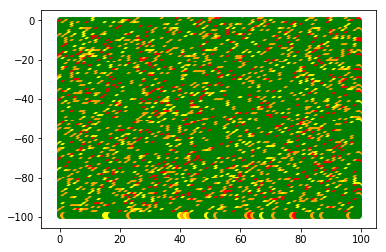

Tour 0:



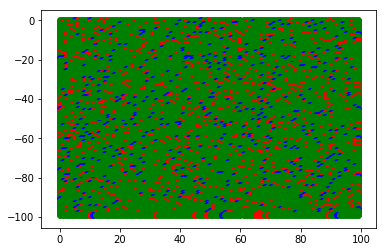

Il y a  0 nouveaux infectés

Il y a 1584 infectés
durée d'exécution du programme:  221.038311958313 s


In [15]:
t0 = time.time() # Temps initial du programme


main(NB_TOURS,X_CLUSTER_ETAT,Y_CLUSTER_ETAT,TAILLE_CLUSTER_ETAT,ETAT_CLUSTER_ETAT,X_CLUSTER_COMPORTEMENT,Y_CLUSTER_COMPORTEMENT,TAILLE_CLUSTER_COMPORTEMENT,ETAT_CLUSTER_COMPORTEMENT,TEMPS_PAUSE,True,False,False,False)


tf = time.time() #Temps final
print("durée d'exécution du programme: ",tf - t0,"s") #Affiche la durée d'execution du programme